*Read section 8.1.1 of the book before using these notes.*

*Note that in this course, lecture notes are not sufficient, you must read the book for better understanding. Lecture notes are just implementing the concepts of the book on a dataset, but not explaining the concepts elaborately.*

In [ ]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(font_scale=1.35)

# import the decision tree regressor
from sklearn.tree import DecisionTreeRegressor, plot_tree, export_graphviz

# split the dataset into training and testing sets
from sklearn.model_selection import train_test_split


from sklearn.model_selection import cross_val_score, GridSearchCV, cross_val_predict, KFold

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer
from sklearn.metrics import root_mean_squared_error, r2_score, make_scorer

We will use the same dataset as in the KNN model for regression trees.

In [2]:
# Load the dataset
car = pd.read_csv('Datasets/car.csv')
car.head()

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize,price
0,vw,Beetle,2014,Manual,55457,Diesel,30,65.3266,1.6,7490
1,vauxhall,GTC,2017,Manual,15630,Petrol,145,47.2049,1.4,10998
2,merc,G Class,2012,Automatic,43000,Diesel,570,25.1172,3.0,44990
3,audi,RS5,2019,Automatic,10,Petrol,145,30.5593,2.9,51990
4,merc,X-CLASS,2018,Automatic,14000,Diesel,240,35.7168,2.3,28990


## Native Support for Missing Values


Starting with **scikit-learn version 1.3**, classical tree-based models in `scikit-learn` have added **native support for missing values**, which simplifies preprocessing and improves model robustness:

-  `DecisionTreeClassifier` supports missing values as of **version 1.3.0**  
-  `RandomForestClassifier` adds support in **version 1.4.0**

This means you no longer need to impute missing values manually before training these models.

To take advantage of this feature, first check your `scikit-learn` version:

In [3]:
import sklearn
print(sklearn.__version__)

1.6.1


If your version is below `1.4.0`, you can upgrade by running:

In [ ]:
# pip install --upgrade scikit-learn

In [4]:
# Make a copy of the original dataset
car_missing = car.copy()

# Randomly add missing values
# Inject missing values into 10% of the 'mileage' column
car_missing.loc[car_missing.sample(frac=0.1, random_state=42).index, 'mileage'] = np.nan
# Inject missing values into 10% of the 'fuelType' and 'engineSize' columns

car_missing.loc[car_missing.sample(frac=0.1, random_state=42).index, 'fuelType'] = np.nan
car_missing.loc[car_missing.sample(frac=0.1, random_state=42).index, 'engineSize'] = np.nan

In [5]:
car_missing.isna().sum()

brand             0
model             0
year              0
transmission      0
mileage         763
fuelType        763
tax               0
mpg               0
engineSize      763
price             0
dtype: int64

In [6]:
# Split the car_missing dataset into features and target
X_missing = car_missing.drop(columns=['price'])
y_missing = car_missing['price']

### Build a regression tree using mileage as the solo predictor

In [7]:
# Use only 'mileage' as the feature
X_mileage = X_missing[['mileage']]
y_mileage = y_missing

In [ ]:
# Create a DecisionTreeRegressor model
reg_tree = DecisionTreeRegressor(random_state=42)

# Fit the model to the data
reg_tree.fit(X_mileage, y_mileage)

DecisionTreeRegressor(random_state=42)

In [9]:
# Predict the target variable using the model
y_pred = reg_tree.predict(X_mileage)

# Calculate the RMSE and R² score
rmse = np.sqrt(np.mean((y_missing - y_pred) ** 2))
r2 = r2_score(y_missing, y_pred)
print(f"RMSE: {rmse:.2f}")
print(f"R²: {r2:.2f}")

RMSE: 8797.85
R²: 0.71


## Building regression trees

In [11]:
X = car.drop(columns=['price'])
y = car['price']

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Using only mileage feature

In [ ]:
# Use only 'mileage' as the feature
X_train_mileage = X_train[['mileage']]
X_test_mileage = X_test[['mileage']]

# Create a DecisionTreeRegressor model
reg_tree = DecisionTreeRegressor(random_state=42, max_depth=3)

# Fit the model to the training data
reg_tree.fit(X_train_mileage, y_train)

# Predict the target variable using the model
y_pred = reg_tree.predict(X_test_mileage)

# Calculate the RMSE and R² score
rmse = np.sqrt(np.mean((y_test - y_pred) ** 2))
r2 = r2_score(y_test, y_pred)
print(f"RMSE using only mileage predictor: {rmse:.2f}")
print(f"R² using only mileage predictor: {r2:.2f}")

RMSE using only mileage predictor: 14437.80
R² using only mileage predictor: 0.29


Let's visualize the tree structure

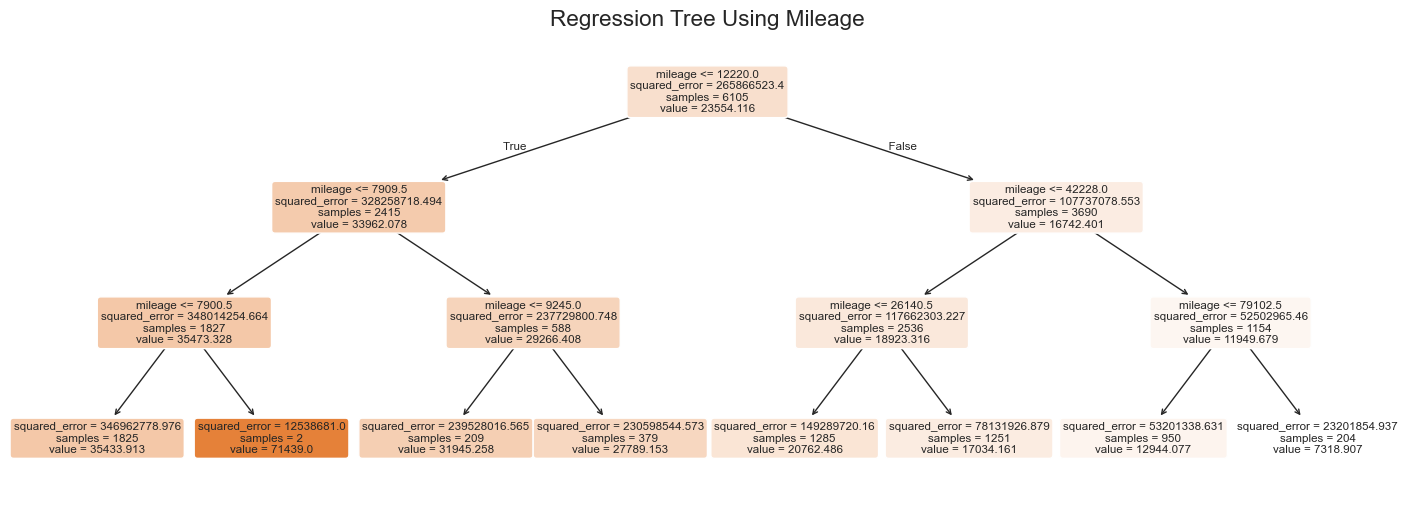

In [ ]:
# Plot the tree
plt.figure(figsize=(18, 6))
plot_tree(reg_tree, feature_names=['mileage'], filled=True, rounded=True)
plt.title("Regression Tree Using Mileage")
plt.show()

Let's visualize how mileage is used in the decision tree below:

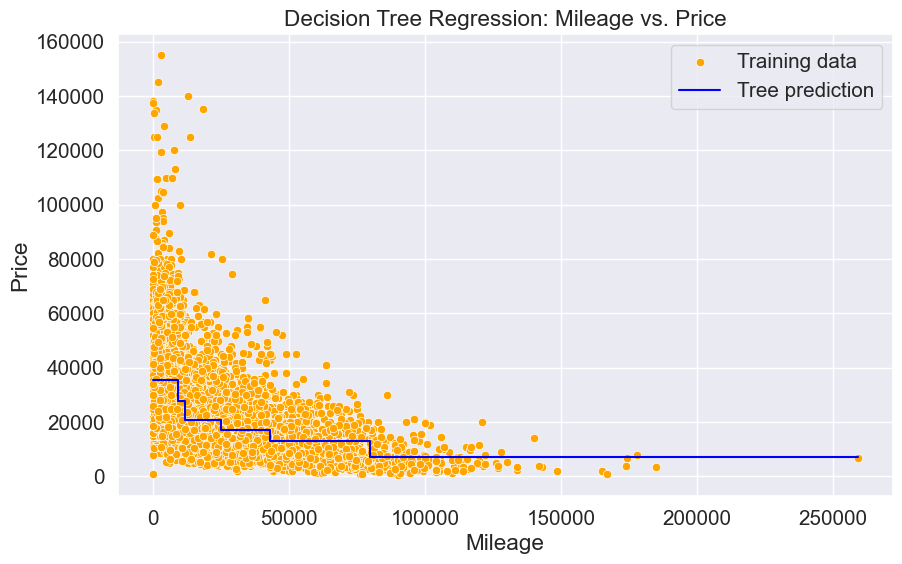

In [62]:
# Create evenly spaced mileage values within the range of training data
Xtest = np.linspace(X_train_mileage['mileage'].min(), X_train_mileage['mileage'].max(), 100).reshape(-1, 1)

# Convert Xtest to a DataFrame with the correct column name
Xtest_df = pd.DataFrame(Xtest, columns=['mileage'])

# Predict using the DataFrame instead of NumPy array
ytest_pred = reg_tree.predict(Xtest_df)

plt.figure(figsize=(10, 6))
sns.scatterplot(x=X_train_mileage['mileage'], y=y_train, color='orange', label='Training data')

# Step plot to reflect piecewise constant predictions
plt.step(Xtest_df['mileage'], ytest_pred, color='blue', label='Tree prediction', where='mid')

plt.xlabel("Mileage")
plt.ylabel("Price")
plt.title("Decision Tree Regression: Mileage vs. Price")
plt.legend()
plt.show()


All cars falling within the same terminal node have the same predicted price, which is seen as flat line segments in the above model curve.

### Using mileage and brand as predictors

In [15]:
X_train.head() 

,brand,model,year,transmission,mileage,fuelType,tax,mpg,engineSize
216,vw,Scirocco,2016,Manual,41167,Diesel,20,55.2654,2.0
4381,merc,CLS Class,2018,Semi-Auto,12078,Diesel,145,47.7624,2.9
6891,hyundi,Santa Fe,2019,Automatic,623,Diesel,145,43.0887,2.2
421,hyundi,IX35,2014,Manual,37095,Diesel,145,53.4862,1.7
505,ford,Edge,2016,Semi-Auto,15727,Diesel,160,49.0741,2.0


In [16]:
# Select features and target
X_train_tree = X_train[['mileage', 'brand']]

X_test_tree = X_test[['mileage', 'brand']]


In [46]:
# One-hot encode the categorical variable 'brand'
X_train_tree_encoded = pd.get_dummies(X_train_tree, columns=['brand'])
X_test_tree_encoded = pd.get_dummies(X_test_tree, columns=['brand'])

In [47]:
model = DecisionTreeRegressor(max_depth=3, random_state=42)
model.fit(X_train_tree_encoded, y_train)

DecisionTreeRegressor(max_depth=3, random_state=42)

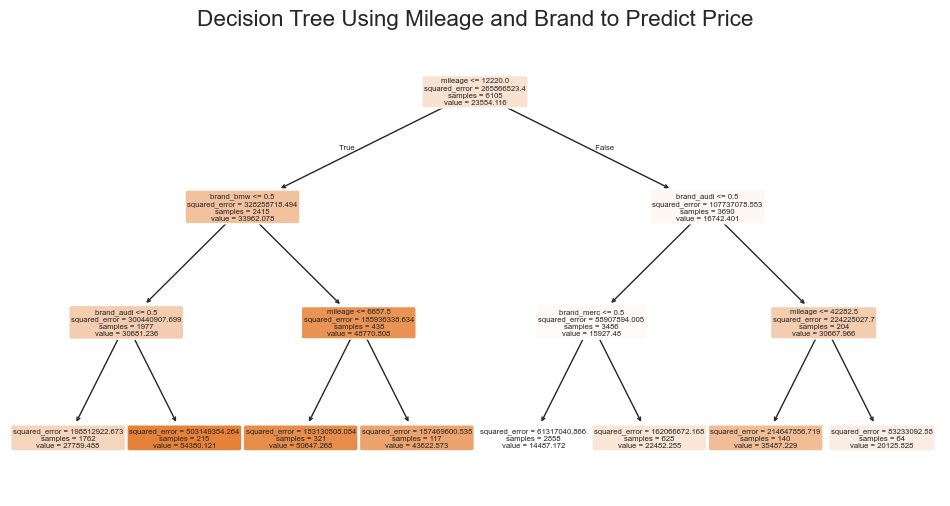

In [48]:
plt.figure(figsize=(12, 6))
plot_tree(model, feature_names=X_train_tree_encoded.columns, filled=True, rounded=True)
plt.title("Decision Tree Using Mileage and Brand to Predict Price")
plt.show()

In [49]:
# Predict the target variable using the model
y_pred_tree = model.predict(X_test_tree_encoded)

# Calculate the RMSE and R² score
rmse_tree = np.sqrt(np.mean((y_test - y_pred_tree) ** 2))
r2_tree = r2_score(y_test, y_pred_tree)
print(f"RMSE using mileage and brand predictor: {rmse_tree:.2f}")
print(f"R² using mileage and brand predictor: {r2_tree:.2f}")

# Compare the performance of the two models
print(f"RMSE using only mileage predictor: {rmse:.2f}")
print(f"RMSE using mileage and brand predictor: {rmse_tree:.2f}")
# The RMSE using mileage and brand predictor is lower than using only mileage predictor.
# This indicates that adding the brand feature improves the model's performance


RMSE using mileage and brand predictor: 12531.44
R² using mileage and brand predictor: 0.46
RMSE using only mileage predictor: 14437.80
RMSE using mileage and brand predictor: 12531.44


### Using all predictors

Now that we've explored a single predictor (`mileage`) and added a second predictor (`brand`), let's take it a step further and use **all available features** to build a more robust model.

We'll construct a **pipeline** that handles necessary preprocessing steps (e.g., categorical encoding) and fits a **Decision Tree Regressor** in a streamlined and reproducible way.

In [ ]:
# extract the categorical columns and put them in a list
categorical_feature = X.select_dtypes(include=['object']).columns.tolist()

# extract the numerical columns and put them in a list
numerical_feature = X.select_dtypes(include=['int64', 'float64']).columns.tolist()


# Create a ColumnTransformer to handle encoding
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_feature)
    ],
    remainder='passthrough',  # Keep numerical feature (mileage) unchanged
    force_int_remainder_cols=False
)

# Create the pipeline
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('regressor', DecisionTreeRegressor(max_depth=4, random_state=42))
])

# Usage:
pipeline.fit(X_train, y_train)
y_pred = pipeline.predict(X_test)

# Calculate the RMSE and R² score
rmse_pipeline = np.sqrt(np.mean((y_test - y_pred) ** 2))
r2_pipeline = r2_score(y_test, y_pred)
print(f"RMSE using pipeline: {rmse_pipeline:.2f}")
print(f"R² using pipeline: {r2_pipeline:.2f}")

RMSE using pipeline: 8186.34
R² using pipeline: 0.77


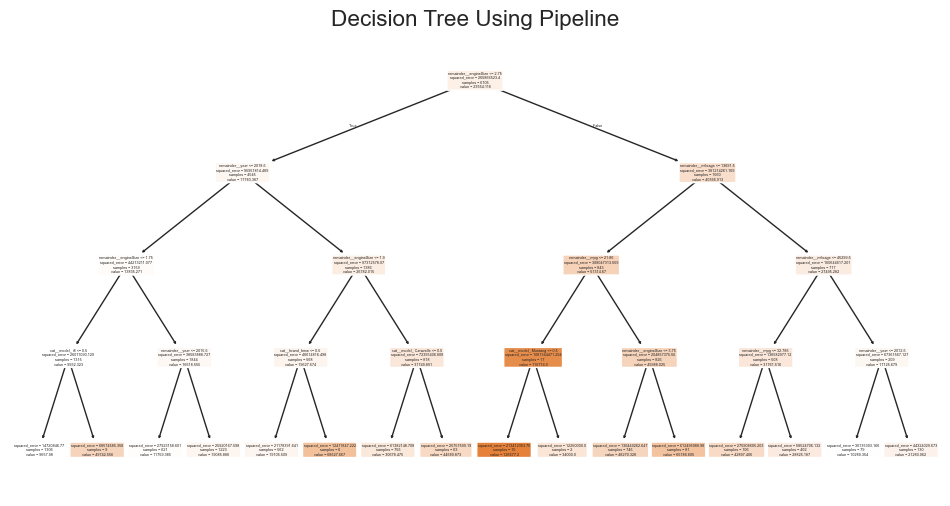

In [72]:
# let's visuzalize the decision tree

plt.figure(figsize=(12, 6))
plot_tree(pipeline.named_steps['regressor'], feature_names=pipeline.named_steps['preprocessor'].get_feature_names_out(), filled=True, rounded=True)
plt.title("Decision Tree Using Pipeline")
plt.show()



## Key Hyperparameters in Decision Tree

In regression trees, **model complexity** is controlled by hyperparameters, tuning them is crucial for balancing **underfitting** and **overfitting**. 


###  Underfitting
- The model is **too simple** to capture patterns in the data.
- High bias, low variance.
- Often caused by:
  - Shallow trees (`max_depth` is too small)
  - Too strict constraints (`min_samples_split` or `min_samples_leaf` is too high)

### Overfitting
- The model is **too complex** and learns noise from the training data.
- Low bias, high variance.
- Often caused by:
  - Deep trees with many splits
  - Very small `min_samples_leaf` or `min_samples_split`


Below are the most commonly used hyperparameters:


### `max_depth`

- Controls the **maximum depth** of the tree.
- If `None`, the tree will expand until all leaves are pure or contain fewer than `min_samples_split` samples.
- Controls overfitting (deep trees → overfit, shallow trees → underfit)
- Typical values: 3 to 20 (start with lower values).


### `min_samples_split`

* The **minimum number of samples** required to split an internal node.
* higher values → simpler trees (reducing overfitting)

### `min_samples_leaf`

* The minimum number of samples required to be at a leaf node.
* Setting this to a higher number can smooth the model by reducing variance.

### `max_features`

- Number of features to consider when looking for the best split.

- Can be set to:
  - `"auto"` or `None`: use all features
  - `"sqrt"`: use the square root of the number of features
  - `"log2"`: use log base 2


In [ ]:
# Define your parameter grid with pipeline step prefix
param_grid = {
    'regressor__max_depth': [3, 5, 7, 10, None],
    'regressor__min_samples_split': [2, 5, 10],
    'regressor__min_samples_leaf': [1, 2, 4],
    'regressor__max_features': ['sqrt', None]
}

# Create custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: root_mean_squared_error(y_true, y_pred),
                          greater_is_better=False)
# Create GridSearchCV object
grid_search = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'RMSE': rmse_scorer,
        'R2': 'r2'
    },
    refit='R2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to training data
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 270 candidates, totalling 1350 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['brand',
                                                                          'model',
                                                                          'transmission',
                                                                          'fuelType'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(max_depth=4,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__ccp_alpha': [0.001, 0.01, 0.1],
                         'regressor__max_depth': [3, 5, 7, 10, None],
                         'regressor__max_features': ['sqrt', None],
                         'regressor__min_samples_leaf': [1, 2, 4],
                         'regressor__min_samples_split': [2, 5, 10]},
             refit='R2',
             scoring={'R2': 'r2',
                      'RMSE': make_scorer(<lambda>, greater_is_better=False, response_method='predict')},
             verbose=1)

The `GridSearchCV` setup evaluates both **RMSE** and **R²** during cross-validation.

- **R²** is used to **select the best model** and is also used to **refit** the model on the entire training set.
- **RMSE** is computed during the process for evaluation purposes, but it is **not used to determine** the best model.

This allows for more comprehensive model assessment while still optimizing based on a single selected metric.

In [ ]:
# Get best estimator and predictions
best_model = grid_search.best_estimator_
y_pred_tuned = best_model.predict(X_test)

# Calculate metrics for tuned model
rmse_tuned = root_mean_squared_error(y_test, y_pred_tuned)
r2_tuned = r2_score(y_test, y_pred_tuned)

In [95]:
print("\n=== Best Parameters ===")
print(grid_search.best_params_)
print("\n=== Tuned Model Performance ===")
print(f"RMSE (Tuned): {rmse_tuned:.2f}")
print(f"R² (Tuned): {r2_tuned:.2f}")
print(f"Improvement in R²: {(r2_tuned - r2_pipeline):.2%}")


=== Best Parameters ===
{'regressor__ccp_alpha': 0.001, 'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}

=== Tuned Model Performance ===
RMSE (Tuned): 4726.17
R² (Tuned): 0.92
Improvement in R²: 15.23%


In [96]:
print("\n=== Best Parameters ===")
print(grid_search.best_params_)
print("\n=== Tuned Model Performance ===")
print(f"RMSE (Tuned): {rmse_tuned:.2f}")
print(f"R² (Tuned): {r2_tuned:.2f}")
print(f"Improvement in R²: {(r2_tuned - r2_pipeline):.2%}")


=== Best Parameters ===
{'regressor__ccp_alpha': 0.001, 'regressor__max_depth': None, 'regressor__max_features': None, 'regressor__min_samples_leaf': 1, 'regressor__min_samples_split': 5}

=== Tuned Model Performance ===
RMSE (Tuned): 4726.17
R² (Tuned): 0.92
Improvement in R²: 15.23%


`GridSearchCV` improves the r squared from 0.77 to 0.92, increased by 15.23%, Let us visualize the mean squared error based on the hyperparameter values. We’ll use the cross validation results stored in the cv_results_ attribute of the GridSearchCV fit() object.

In [97]:
#Detailed results of k-fold cross validation
cv_results = pd.DataFrame(grid_search.cv_results_)
cv_results.head()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_regressor__ccp_alpha,param_regressor__max_depth,param_regressor__max_features,param_regressor__min_samples_leaf,param_regressor__min_samples_split,params,...,std_test_RMSE,rank_test_RMSE,split0_test_R2,split1_test_R2,split2_test_R2,split3_test_R2,split4_test_R2,mean_test_R2,std_test_R2,rank_test_R2
0,0.075184,0.013049,0.009999,0.001052,0.001,3,sqrt,1,2,"{'regressor__ccp_alpha': 0.001, 'regressor__ma...",...,607.458245,250,0.42527,0.37778,0.538252,0.37182,0.364829,0.415590,0.064903,250
1,0.078505,0.014115,0.010804,0.001051,0.001,3,sqrt,1,5,"{'regressor__ccp_alpha': 0.001, 'regressor__ma...",...,607.458245,250,0.42527,0.37778,0.538252,0.37182,0.364829,0.415590,0.064903,250
2,0.077370,0.011081,0.010873,0.000946,0.001,3,sqrt,1,10,"{'regressor__ccp_alpha': 0.001, 'regressor__ma...",...,606.926403,244,0.42527,0.37778,0.538252,0.37182,0.365155,0.415655,0.064852,244
3,0.036274,0.036182,0.010617,0.000345,0.001,3,sqrt,2,2,"{'regressor__ccp_alpha': 0.001, 'regressor__ma...",...,607.458245,250,0.42527,0.37778,0.538252,0.37182,0.364829,0.415590,0.064903,250
4,0.018702,0.003564,0.012120,0.004090,0.001,3,sqrt,2,5,"{'regressor__ccp_alpha': 0.001, 'regressor__ma...",...,607.458245,250,0.42527,0.37778,0.538252,0.37182,0.364829,0.415590,0.064903,250


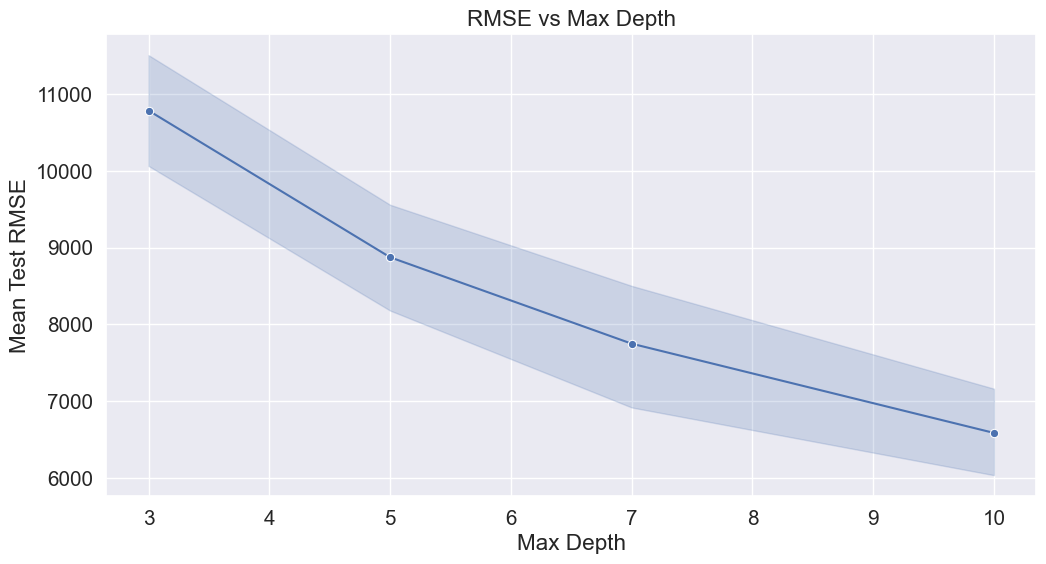

In [91]:
# Plotting the RMSE for different max_depth values
plt.figure(figsize=(12, 6))
sns.lineplot(data=cv_results, x='param_regressor__max_depth', y=np.abs(cv_results['mean_test_RMSE']), marker='o')
plt.xlabel('Max Depth')
plt.ylabel('Mean Test RMSE')
plt.title('RMSE vs Max Depth');

### Output feature importance

=== Top 10 Feature Importances ===
                   Feature  Importance
112  remainder__engineSize    0.437921
109     remainder__mileage    0.173215
108        remainder__year    0.149303
111         remainder__mpg    0.086922
98          cat__model_ i8    0.017971
2          cat__brand_ford    0.013837
92          cat__model_ X7    0.013477
110         remainder__tax    0.011502
60     cat__model_ Mustang    0.009517
86     cat__model_ V Class    0.008147


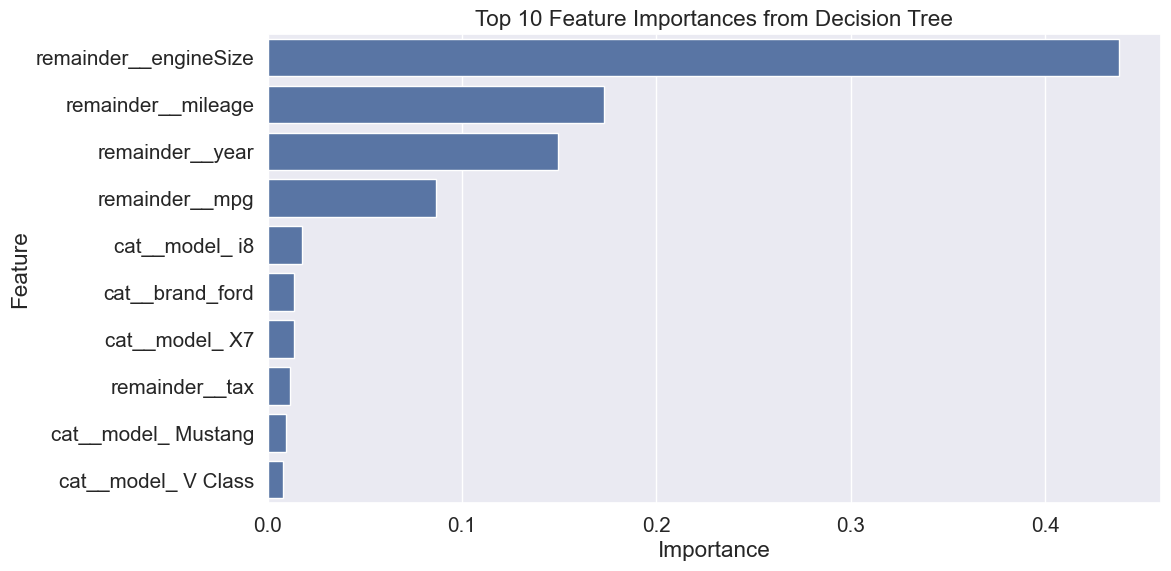

In [102]:
# Get feature importances and names
feature_importances = best_model.named_steps['regressor'].feature_importances_
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Create DataFrame and select top 10
feature_importance_df = (
    pd.DataFrame({'Feature': feature_names, 'Importance': feature_importances})
    .sort_values(by='Importance', ascending=False)
    .head(10)  # Keep only top 10 features
)

# Print top 10 features
print("=== Top 10 Feature Importances ===")
print(feature_importance_df)

# Plot top 10 features
plt.figure(figsize=(12, 6))
sns.barplot(data=feature_importance_df, x='Importance', y='Feature')
plt.title('Top 10 Feature Importances from Decision Tree')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.tight_layout()
plt.show()

## Cost-Complexity Pruning (`ccp_alpha`)

Cost-complexity pruning is a post-pruning technique used to reduce the size of a decision tree by removing sections that provide little to no improvement in prediction accuracy. It helps prevent **overfitting** and improves **model generalization**.


###  Key Idea

Each subtree in a decision tree has an associated **cost-complexity score**:

$
R_\alpha(T) = R(T) + \alpha \cdot |T|
$

- $ R(T) $: Total training error of the tree \( T \)
- $ |T| $: Number of leaf nodes in the tree
- $alpha$ (**ccp_alpha**): Complexity parameter that penalizes tree size

As $alpha$ increases, the tree is **pruned more aggressively**.


###  Parameter: `ccp_alpha` in scikit-learn

- Available in `DecisionTreeRegressor` and `DecisionTreeClassifier`
- Default: `ccp_alpha = 0.0` (no pruning)
- Increasing `ccp_alpha` encourages simpler trees by penalizing extra leaf nodes


In [104]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer, mean_squared_error
import numpy as np

# Define your parameter grid with pipeline step prefix
param_grid = {
    'regressor__ccp_alpha': [0.0, 0.001, 0.01, 0.1]
}

# Create custom scorer for RMSE
rmse_scorer = make_scorer(lambda y_true, y_pred: np.sqrt(mean_squared_error(y_true, y_pred)),
                          greater_is_better=False)

# Create GridSearchCV object
grid_search_ccp = GridSearchCV(
    estimator=pipeline,
    param_grid=param_grid,
    scoring={
        'RMSE': rmse_scorer,
        'R2': 'r2'
    },
    refit='R2',
    cv=5,
    n_jobs=-1,
    verbose=1
)

# Fit the grid search to training data
grid_search_ccp.fit(X_train, y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('preprocessor',
                                        ColumnTransformer(force_int_remainder_cols=False,
                                                          remainder='passthrough',
                                                          transformers=[('cat',
                                                                         OneHotEncoder(handle_unknown='ignore'),
                                                                         ['brand',
                                                                          'model',
                                                                          'transmission',
                                                                          'fuelType'])])),
                                       ('regressor',
                                        DecisionTreeRegressor(max_depth=4,
                                                              random_state=42))]),
             n_jobs=-1,
             param_grid={'regressor__ccp_alpha': [0.0, 0.001, 0.01, 0.1]},
             refit='R2',
             scoring={'R2': 'r2',
                      'RMSE': make_scorer(<lambda>, greater_is_better=False, response_method='predict')},
             verbose=1)

In [113]:
encoder = OneHotEncoder(handle_unknown='ignore', sparse_output=False)

X_train_encoded = encoder.fit_transform(X_train[categorical_feature])
X_test_encoded = encoder.transform(X_test[categorical_feature])

# Convert the encoded features back to DataFrame
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=encoder.get_feature_names_out(categorical_feature))
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=encoder.get_feature_names_out(categorical_feature))

# Concatenate the encoded features with the original numerical features
X_train_final = pd.concat([X_train_encoded_df, X_train[numerical_feature].reset_index(drop=True)], axis=1)
X_test_final = pd.concat([X_test_encoded_df, X_test[numerical_feature].reset_index(drop=True)], axis=1)

# Check the final shape of the training and testing sets
print("Training set shape:", X_train_final.shape)
print("Testing set shape:", X_test_final.shape)
# Check the first few rows of the final training set
X_train_final.head()
# Check the first few rows of the final testing set

Training set shape: (6105, 113)
Testing set shape: (1527, 113)


,brand_audi,brand_bmw,brand_ford,brand_hyundi,brand_merc,brand_skoda,brand_toyota,brand_vauxhall,brand_vw,model_ 6 Series,...,fuelType_Diesel,fuelType_Electric,fuelType_Hybrid,fuelType_Other,fuelType_Petrol,year,mileage,tax,mpg,engineSize
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2016,41167,20,55.2654,2.0
1,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2018,12078,145,47.7624,2.9
2,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2019,623,145,43.0887,2.2
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2014,37095,145,53.4862,1.7
4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,2016,15727,160,49.0741,2.0


In [114]:
model = DecisionTreeRegressor(random_state = 1)#model without any restrictions
path= model.cost_complexity_pruning_path(X_train_final,y_train)# Compute the pruning path during Minimal Cost-Complexity Pruning.

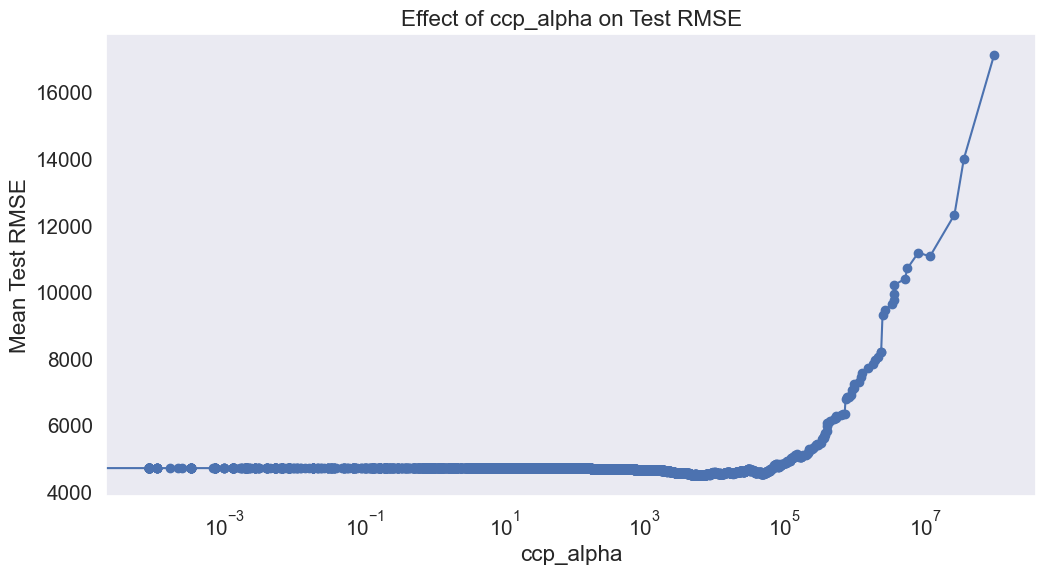

In [118]:
# Extract the effective alphas and the corresponding performance metrics
ccp_alphas = path.ccp_alphas
impurities = path.impurities
# Create a DataFrame to store the results
ccp_results = pd.DataFrame({'ccp_alpha': ccp_alphas, 'impurity': impurities})
# Fit the model for each alpha value and calculate the mean test score
mean_test_scores = []
for alpha in ccp_alphas:
    model = DecisionTreeRegressor(random_state=1, ccp_alpha=alpha)
    model.fit(X_train_final, y_train)
    y_pred = model.predict(X_test_final)
    mean_test_scores.append(np.sqrt(mean_squared_error(y_test, y_pred)))
# Add the mean test scores to the DataFrame
ccp_results['mean_test_score'] = mean_test_scores
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(ccp_results['ccp_alpha'], ccp_results['mean_test_score'], marker='o')
plt.xlabel('ccp_alpha')
plt.ylabel('Mean Test RMSE')
plt.title('Effect of ccp_alpha on Test RMSE')
plt.xscale('log')
plt.grid()